## Weather Classification
### Model Training

In [33]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PMML Pipeline(s)
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml.preprocessing import LookupTransformer
from sklearn2pmml.preprocessing import DaysSinceYearTransformer
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.decoration import CategoricalDomain
from sklearn2pmml.decoration import DateTimeDomain
from sklearn2pmml.feature_extraction.text import Splitter

# Data Mapping
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# Classification Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Accuracy
from sklearn.metrics import accuracy_score

# Features Importance
from sklearn.inspection import permutation_importance

# Model Selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [34]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [35]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [36]:
from sklearn.model_selection import train_test_split

# Newspaper churn dataset
# It contains 15.855 records and 19 columns including the target variable Subscriber (YES/NO).
# The majority of the features is categorial.
df = pd.read_csv('../../../data/weather-classification-clean.csv')

X = df.drop('target', axis=1)
y = df['target']

In [37]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
X_train.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
dtype: object

In [39]:
# Selecting categorical, numeric, datatime, and text features
numeric_features = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Cloud9am','Cloud3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
datetime_features = ['Date']
text_features = []
drop_features = ['Pressure3pm', 'Temp3pm', 'Temp9am']

In [40]:
mapper = DataFrameMapper(
    [([col_num], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]) for col_num in numeric_features] +
    [([col_cat], [CategoricalDomain(), SimpleImputer(strategy='most_frequent'), PMMLLabelEncoder(), StandardScaler()]) for col_cat in categorical_features] +
    [([col_dat], [DateTimeDomain(), DaysSinceYearTransformer(year = 1968), StandardScaler()]) for col_dat in datetime_features] +
    [(col_txt,   [CategoricalDomain(), CountVectorizer(tokenizer=Splitter(), max_features=5)]) for col_txt in text_features],
    drop_cols=drop_features,
    input_df=True,
    df_out=True
)

In [41]:
X_trans = mapper.fit_transform(X_test)
X_trans

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Date
2015,0.113541,0.628512,-0.061535,-0.051639,-0.813016,0.516543,0.257719,-0.479475,-1.788033,0.163504,0.165716,-1.567930,1.178019,-1.538798,0.013985,1.937163,0.673854
23070,-1.253099,-1.082565,-0.376834,-1.790601,-1.523968,-1.223835,1.761454,0.558747,1.306710,0.163504,0.165716,-1.254714,-1.374923,0.863932,-1.078350,-0.516219,-0.324604
11714,0.892007,1.542193,-0.376834,-0.209727,0.727381,0.168467,-0.783329,-1.221062,0.476016,-1.691364,-0.826907,0.624587,-1.587669,-1.757228,-1.515285,-0.516219,-0.853463
22322,1.237992,0.944147,1.424873,1.134016,0.490397,0.980643,0.720407,0.262112,-0.696729,0.163504,0.165716,-1.254714,-0.736688,-1.320368,-1.296818,1.937163,-1.304055
3520,0.511423,0.827860,2.190599,-0.051639,-0.694524,-0.295633,0.489063,0.014917,-0.208085,0.163504,0.165716,-0.315063,0.965274,-1.101938,-0.422949,1.937163,-0.989870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,-1.460690,-0.467906,-0.376834,-0.604945,-0.457540,-0.991784,-1.130345,-1.270501,0.052525,-1.691364,-2.315842,0.311370,0.965274,1.519221,1.761723,-0.516219,-1.193363
17552,0.130840,-0.982891,0.073593,2.872977,2.623254,1.444744,-0.899001,0.064356,-1.055068,-1.227647,-1.323219,1.251020,1.603510,1.519221,1.761723,1.937163,-0.288825
10272,0.130840,-0.849992,2.866239,0.422623,0.845873,0.516543,0.720407,0.855382,2.577184,1.554655,1.654651,0.311370,1.603510,0.863932,1.106321,1.937163,0.880701
7730,1.272590,2.555550,-0.331791,-0.051639,0.490397,-0.527684,-1.303853,-1.715453,-0.631576,-2.155080,-1.323219,-0.001847,1.603510,-1.101938,1.761723,-0.516219,0.751002


## Ensemble of models

In [11]:
# Ensemble of models
estimator = []
estimator.append(('lrc',LogisticRegression(warm_start=True, max_iter=400)))
estimator.append(('xgb', XGBClassifier(tree_method="hist", verbosity=0, silent=True)))
estimator.append(('rfc', RandomForestClassifier()))
estimator.append(('dtc', DecisionTreeClassifier()))

In [12]:
ppl_ensemble = PMMLPipeline([
    ("mapper", mapper),
    ('ensemble', VotingClassifier(estimators = estimator, voting ='soft'))
])

In [13]:
display(ppl_ensemble)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                features=[(['MinTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['MaxTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Rainfall'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['WindGus...
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['WindDir3pm'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['RainToday'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['Date'],
                           [DateTimeDomain(),
                            DaysSinceYearTransformer(year=1968),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingClassifier(estimators=[('lrc',
                              LogisticRegression(max_iter=400,
                                                 warm_start=True)),
                             ('xgb',
                              XGBClassifier(silent=True, tree_method='hist',
                                            verbosity=0)),
                             ('rfc', RandomForestClassifier()),
                             ('dtc', DecisionTreeClassifier())],
                 voting='soft'))])

## Hyper-parameter Tuning

In [15]:
ppl_ensemble.get_params()

{'apply_transformer': None,
 'header': None,
 'memory': None,
 'predict_proba_transformer': None,
 'predict_transformer': None,
 'steps': [('mapper',
   DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                   features=[(['MinTemp'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['MaxTemp'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['Rainfall'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['WindGus...
                               PMMLLabelEncoder(), StandardScaler()]),
                        

In [18]:
# Hyper-parameter
hyper_params = {
    'ensemble__lrc__solver': ['newton-cg'],
    'ensemble__xgb__reg_alpha': [0.1,0.5],
    'ensemble__rfc__max_depth': [7,10],
    'ensemble__dtc__max_depth': [7,10]
}

cv_rsf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
searcher = RandomizedSearchCV(ppl_ensemble, param_distributions=hyper_params, scoring='roc_auc', verbose=2, cv=cv_rsf)

In [19]:
# Perform model training and hyper-parmeter tuning
searcher.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   4.1s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   3.8s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   3.9s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   3.8s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   4.1s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   4.0s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solv

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=2, random_state=None),
                   estimator=PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'], features=[(['MinTemp'], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]), (['MaxTemp'], [ContinuousDomain(), SimpleImputer(strate...rue)), ('xgb', XGBClassifier(silent=True, tree_method='hist', verbosity=0)), ('rfc', RandomForestClassifier()), ('dtc', DecisionTreeClassifier())], voting='soft'))]),
                   param_distributions={'ensemble__dtc__max_depth': [7, 10],
                                        'ensemble__lrc__solver': ['newton-cg'],
                                        'ensemble__rfc__max_depth': [7, 10],
                                        'ensemble__xgb__reg_alpha': [0.1, 0.5]},
                   scoring='roc_auc', verbose=2)

In [20]:
# Select best model
best_pipeline = searcher.best_estimator_
best_params = searcher.best_params_
best_pipeline.verify(X_train.sample(n = 10))

In [21]:
display(best_pipeline)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                features=[(['MinTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['MaxTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Rainfall'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['WindGus...
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['WindDir3pm'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['RainToday'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['Date'],
                           [DateTimeDomain(),
                            DaysSinceYearTransformer(year=1968),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingClassifier(estimators=[('lrc',
                              LogisticRegression(max_iter=400,
                                                 solver='newton-cg',
                                                 warm_start=True)),
                             ('xgb',
                              XGBClassifier(reg_alpha=0.1, silent=True,
                                            tree_method='hist', verbosity=0)),
                             ('rfc', RandomForestClassifier(max_depth=7)),
                             ('dtc', DecisionTreeClassifier(max_depth=7))],
                 voting='soft'))])

In [22]:
best_params

{'ensemble__xgb__reg_alpha': 0.1,
 'ensemble__rfc__max_depth': 7,
 'ensemble__lrc__solver': 'newton-cg',
 'ensemble__dtc__max_depth': 7}

In [23]:
y_pred = best_pipeline.predict(X_test)

ValueError: ['MinTemp']: Data contains 1 invalid values

In [44]:
# using accuracy_score
from sklearn.metrics import f1_score

print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 86.6%
The model f1 score is: 85.3%


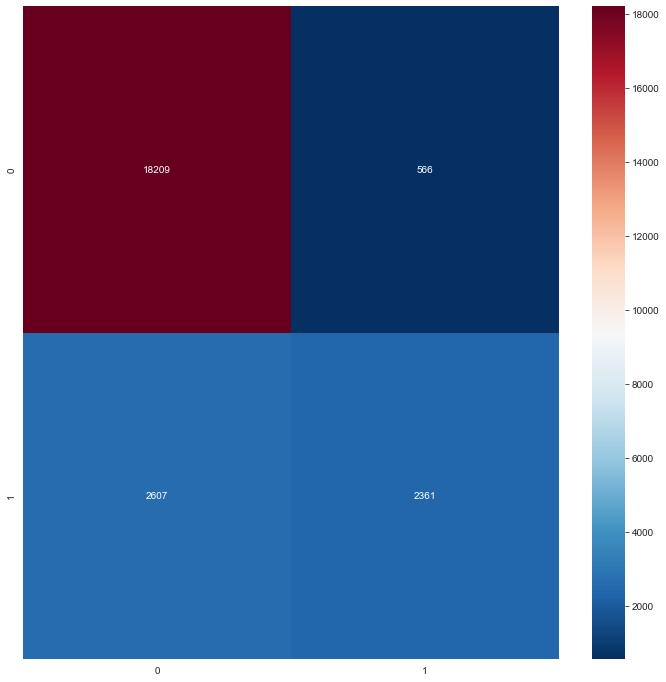

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=best_pipeline.classes_, yticklabels=best_pipeline.classes_, fmt='g', annot=True)
plt.show()

In [57]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(pi_result, features_name):
    """ bar plot the feature importance """
    plt.figure(figsize=(30, 30))
    fig, ax = plt.subplots()

    indices = pi_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             pi_result['importances_mean'][indices],
             xerr=pi_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    tmp = np.array(features_name)
    ax.set_yticklabels(tmp[indices])
    ax.set_title("Permutation importance")

# ppl_ensemble.fit(X_test,y_test)
pi_result = permutation_importance(ppl_ensemble, X_test, y_test)
plot_feature_importances(pi_result, X_test.columns)

[17 14 18 19  8  9 15  7  5 10  1 13  0  2  3 11  4 16  6 12]
[0.         0.         0.         0.00737871 0.01836253 0.01839623
 0.01954178 0.02479784 0.02614555 0.02796496 0.02981806 0.03160377
 0.03477089 0.03557951 0.03571429 0.0370283  0.04727089 0.05309973
 0.05643531 0.18113208]


## Save the model

In [51]:
# Save the best model in PMML format
sklearn2pmml(best_pipeline, "../../../data/weather-classification-ensemble-classifier.pmml")